Response Status Code: 200
Bitcoin Weekly Data (First 5 Rows):
        Date  Bitcoin_Price
0 2015-05-01         235.97
1 2015-05-08         228.99
2 2015-05-15         237.10
3 2015-05-22         234.11
4 2015-05-29         236.44
Alpha Vantage Response Status Code: 200

Gold Weekly Data (First 5 Rows):
        Date  Gold_Price
0 2015-05-01      113.08
1 2015-05-08      113.97
2 2015-05-15      117.53
3 2015-05-22      115.60
4 2015-05-29      114.10

Merged Data (First 5 Rows):
        Date  Bitcoin_Price  Gold_Price
0 2015-05-01         235.97      113.08
1 2015-05-08         228.99      113.97
2 2015-05-15         237.10      117.53
3 2015-05-22         234.11      115.60
4 2015-05-29         236.44      114.10


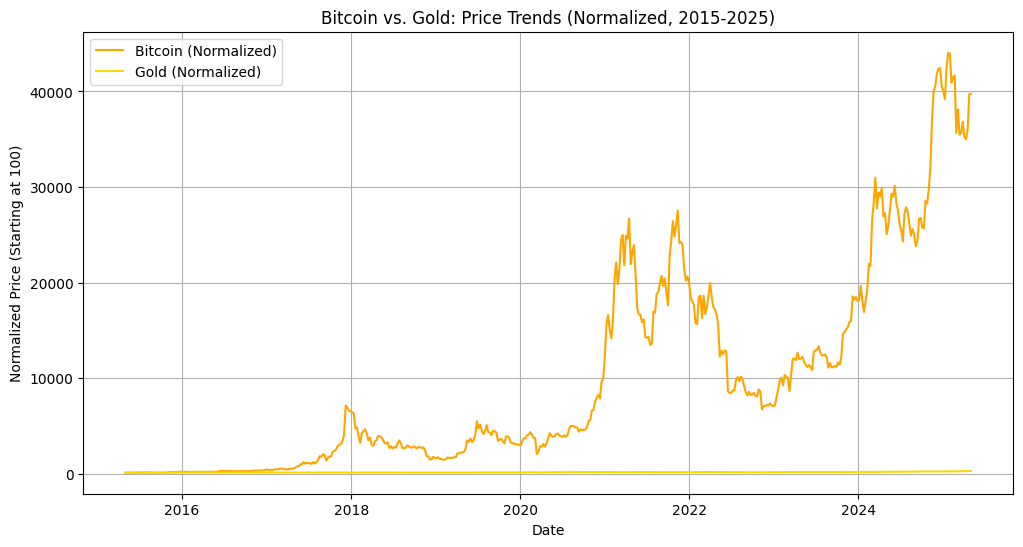

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
!pip install requests yfinance pandas

import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time

# --- Fetch Bitcoin Data from Blockchain.com ---
start_date = int(datetime(2015, 5, 1).timestamp())
end_date = int(datetime(2025, 5, 1).timestamp())
url = f"https://api.blockchain.info/charts/market-price?timespan=10years&format=json&start={start_date}&end={end_date}"

try:
    response = requests.get(url)
    print(f"Response Status Code: {response.status_code}")

    if response.status_code == 200:
        data = response.json()
        if "values" in data:
            bitcoin_data = []
            for entry in data["values"]:
                date = datetime.fromtimestamp(entry["x"]).strftime('%Y-%m-%d')
                price = entry["y"]
                bitcoin_data.append([date, price])

            bitcoin_df = pd.DataFrame(bitcoin_data, columns=['Date', 'Bitcoin_Price'])
            bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])
            bitcoin_df.set_index('Date', inplace=True)
            bitcoin_weekly = bitcoin_df.resample('W-FRI').last().reset_index()
            print("Bitcoin Weekly Data (First 5 Rows):")
            print(bitcoin_weekly.head())
        else:
            print("Error: 'values' key not found in API response.")
            print("API Response:", data)
    else:
        print(f"API Request Failed with Status Code: {response.status_code}")
        print("API Response:", response.json())
except Exception as e:
    print(f"An error occurred: {str(e)}")

# --- Fetch Gold Data from Alpha Vantage using GLD (SPDR Gold Shares ETF) ---
def fetch_gold_data_alpha_vantage(symbol, start_date, end_date, apikey, retries=3, delay=60):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    gold_data = []

    # Alpha Vantage free tier has a limit of ~25 calls/day or 500 calls/month
    for attempt in range(retries):
        try:
            url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={apikey}&outputsize=full"
            response = requests.get(url)
            print(f"Alpha Vantage Response Status Code: {response.status_code}")

            if response.status_code == 200:
                data = response.json()
                if "Time Series (Daily)" in data:
                    for date, values in data["Time Series (Daily)"].items():
                        date_dt = pd.to_datetime(date)
                        if start_date <= date_dt <= end_date:
                            price = float(values["4. close"])
                            gold_data.append([date, price])
                    break  # Success, exit retry loop
                else:
                    print(f"Error fetching gold data: {data}")
                    return None
            else:
                print(f"Alpha Vantage Request Failed with Status Code: {response.status_code}")
                return None
        except Exception as e:
            print(f"Attempt {attempt + 1}/{retries} failed with error: {str(e)}")
            if attempt < retries - 1:
                print(f"Retrying after {delay} seconds...")
                time.sleep(delay)
            else:
                print("Max retries reached. Could not fetch gold data from Alpha Vantage.")
                return None

    # Create DataFrame and resample to weekly
    if gold_data:
        gold_df = pd.DataFrame(gold_data, columns=['Date', 'Gold_Price'])
        gold_df['Date'] = pd.to_datetime(gold_df['Date'])
        gold_df.set_index('Date', inplace=True)
        gold_weekly = gold_df.resample('W-FRI').last().reset_index()
        return gold_weekly
    else:
        return None

# Replace with your Alpha Vantage API key
alpha_vantage_api_key = "YOUR_API_KEY"  # Replace with your actual API key
gold_df = fetch_gold_data_alpha_vantage('GLD', '2015-05-01', '2025-05-02', alpha_vantage_api_key)

if gold_df is not None and not gold_df.empty:
    print("\nGold Weekly Data (First 5 Rows):")
    print(gold_df.head())
else:
    print("Failed to fetch gold data from Alpha Vantage. Please check your API key or try again later.")
    gold_df = None

# --- Merge the Datasets ---
if gold_df is not None and not gold_df.empty:
    merged_df = pd.merge(bitcoin_weekly, gold_df, on='Date', how='inner')
    print("\nMerged Data (First 5 Rows):")
    print(merged_df.head())

    # --- Plot the Data ---
    # Normalize prices to start at 100 for comparison
    merged_df['Bitcoin_Normalized'] = merged_df['Bitcoin_Price'] / merged_df['Bitcoin_Price'].iloc[0] * 100
    merged_df['Gold_Normalized'] = merged_df['Gold_Price'] / merged_df['Gold_Price'].iloc[0] * 100

    plt.figure(figsize=(12, 6))
    plt.plot(merged_df['Date'], merged_df['Bitcoin_Normalized'], label='Bitcoin (Normalized)', color='orange')
    plt.plot(merged_df['Date'], merged_df['Gold_Normalized'], label='Gold (Normalized)', color='gold')
    plt.title('Bitcoin vs. Gold: Price Trends (Normalized, 2015-2025)')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price (Starting at 100)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Save the Merged Data ---
    merged_df.to_csv('bitcoin_vs_gold_raw_10years.csv', index=False)
    from google.colab import files
    files.download('bitcoin_vs_gold_raw_10years.csv')
else:
    print("Cannot proceed with merging and plotting due to missing gold data.")